# Pretrained model - Feature Extraction w/ Data Augmentation
## ONLY USE WITH GPU!!

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
# The path to the directory where the original
# dataset was uncompressed
original_normal_dir = r'.\data\OCT2017\train\NORMAL'
original_cnv_dir = r'.\data\OCT2017\train\CNV'
original_dme_dir = r'.\data\OCT2017\train\DME'
original_drus_dir = r'.\data\OCT2017\train\DRUSEN'

# The directory where we will
# store our smaller dataset
base_dir = r'.\data\OCT2017\stratified_data'
# os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# Directory with our training NORMAL pictures
train_norm_dir = os.path.join(train_dir, 'NORMAL')
# os.mkdir(train_norm_dir)

# Directory with our training CNV pictures
train_cnv_dir = os.path.join(train_dir, 'CNV')
# os.mkdir(train_cnv_dir)

# Directory with our training DME pictures
train_dme_dir = os.path.join(train_dir, 'DME')
# os.mkdir(train_dme_dir)

# Directory with our training DRUSEN pictures
train_drus_dir = os.path.join(train_dir, 'DRUSEN')
# os.mkdir(train_drus_dir)

# Directory with our validation NORMAL pictures
validation_norm_dir = os.path.join(validation_dir, 'NORMAL')
# os.mkdir(validation_norm_dir)

# Directory with our validation CNV pictures
validation_cnv_dir = os.path.join(validation_dir, 'CNV')
# os.mkdir(validation_cnv_dir)

# Directory with our validation DME pictures
validation_dme_dir = os.path.join(validation_dir, 'DME')
# os.mkdir(validation_dme_dir)

# Directory with our validation DRUSEN pictures
validation_drus_dir = os.path.join(validation_dir, 'DRUSEN')
# os.mkdir(validation_drus_dir)

# Directory with our test NORMAL pictures
test_norm_dir = os.path.join(test_dir, 'NORMAL')
# os.mkdir(test_norm_dir)

# Directory with our test CNV pictures
test_cnv_dir = os.path.join(test_dir, 'CNV')
# os.mkdir(test_cnv_dir)

# Directory with our test DME pictures
test_dme_dir = os.path.join(test_dir, 'DME')
# os.mkdir(test_dme_dir)

# Directory with our test DRUSEN pictures
test_drus_dir = os.path.join(test_dir, 'DRUSEN')
# os.mkdir(test_drus_dir)

In [4]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Adding densley connected classifier on to of convolution base

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 16,813,124
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [9]:
conv_base.trainable = False

In [10]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


## Batch_size = 256

In [32]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [33]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [35]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 195s 2s/step - loss: 0.2065 - acc: 0.9286 - val_loss: 0.1969 - val_acc: 0.9228
Epoch 2/50
128/128 [==============================] - 181s 1s/step - loss: 0.2115 - acc: 0.9270 - val_loss: 0.3003 - val_acc: 0.9288
Epoch 3/50
128/128 [==============================] - 181s 1s/step - loss: 0.2024 - acc: 0.9291 - val_loss: 0.2796 - val_acc: 0.9306
Epoch 4/50
128/128 [==============================] - 178s 1s/step - loss: 0.2096 - acc: 0.9269 - val_loss: 0.1617 - val_acc: 0.9359
Epoch 5/50
128/128 [==============================] - 179s 1s/step - loss: 0.1995 - acc: 0.9322 - val_loss: 0.2487 - val_acc: 0.9265
Epoch 6/50
128/128 [==============================] - 179s 1s/step - loss: 0.2032 - acc: 0.9285 - val_loss: 0.2489 - val_acc: 0.9313
Epoch 7/50
128/128 [==============================] - 179s 1s/step - loss: 0.1996 - acc: 0.9311 - val_loss: 0.2149 - val_acc: 0.9339
Epoch 8/50
128/128 [==============================] - 179s 1s/step - 

In [37]:
model.save('VGG16_batch256.h5')

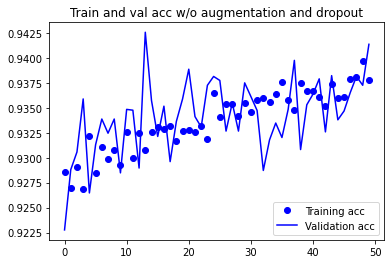

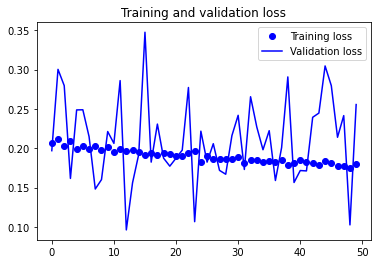

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

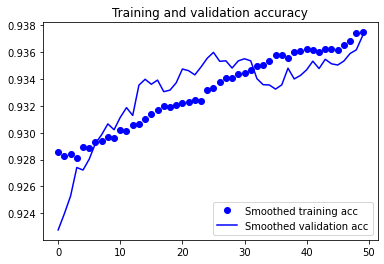

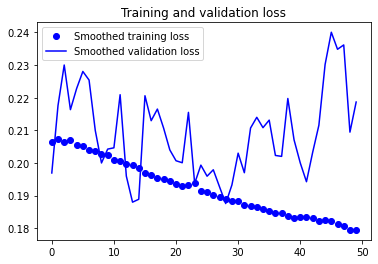

In [39]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.9480000138282776
Wall time: 9.99 s


## Batch_size = 128

In [24]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [25]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [27]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 100s 777ms/step - loss: 0.2566 - acc: 0.9108 - val_loss: 0.1664 - val_acc: 0.9111
Epoch 2/50
128/128 [==============================] - 93s 729ms/step - loss: 0.2509 - acc: 0.9147 - val_loss: 0.1897 - val_acc: 0.9036
Epoch 3/50
128/128 [==============================] - 91s 713ms/step - loss: 0.2573 - acc: 0.9079 - val_loss: 0.1788 - val_acc: 0.9211
Epoch 4/50
128/128 [==============================] - 94s 736ms/step - loss: 0.2480 - acc: 0.9124 - val_loss: 0.4358 - val_acc: 0.9083
Epoch 5/50
128/128 [==============================] - 94s 736ms/step - loss: 0.2450 - acc: 0.9164 - val_loss: 0.1660 - val_acc: 0.9233
Epoch 6/50
128/128 [==============================] - 92s 717ms/step - loss: 0.2489 - acc: 0.9124 - val_loss: 0.2748 - val_acc: 0.9119
Epoch 7/50
128/128 [==============================] - 92s 717ms/step - loss: 0.2412 - acc: 0.9142 - val_loss: 0.3063 - val_acc: 0.9191
Epoch 8/50
128/128 [==============================] - 

In [28]:
model.save('VGG16_batch64.h5')

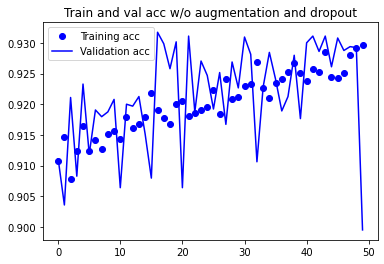

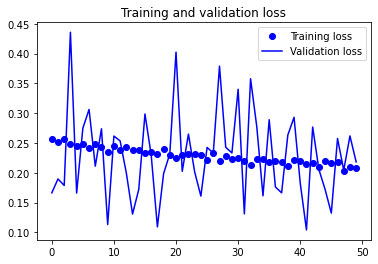

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

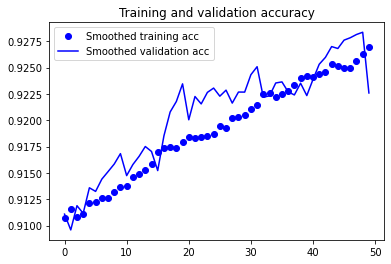

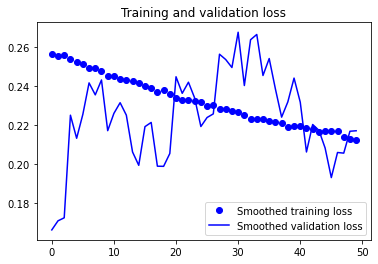

In [30]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.8949999809265137
Wall time: 11.1 s


## Batch_size=64; 

In [15]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [18]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 48s 376ms/step - loss: 0.6506 - acc: 0.7644 - val_loss: 0.6255 - val_acc: 0.8181
Epoch 2/50
128/128 [==============================] - 46s 362ms/step - loss: 0.5412 - acc: 0.8053 - val_loss: 0.4581 - val_acc: 0.8462
Epoch 3/50
128/128 [==============================] - 46s 362ms/step - loss: 0.4701 - acc: 0.8306 - val_loss: 0.5009 - val_acc: 0.8478
Epoch 4/50
128/128 [==============================] - 45s 353ms/step - loss: 0.4403 - acc: 0.8402 - val_loss: 0.4446 - val_acc: 0.8653
Epoch 5/50
128/128 [==============================] - 45s 355ms/step - loss: 0.4058 - acc: 0.8510 - val_loss: 0.4122 - val_acc: 0.8675
Epoch 6/50
128/128 [==============================] - 47s 364ms/step - loss: 0.3917 - acc: 0.8597 - val_loss: 0.3334 - val_acc: 0.8734
Epoch 7/50
128/128 [==============================] - 47s 368ms/step - loss: 0.3865 - acc: 0.8622 - val_loss: 0.2904 - val_acc: 0.8484
Epoch 8/50
128/128 [==============================] - 4

In [19]:
model.save('VGG16_batch64.h5')

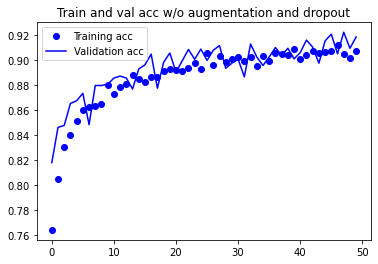

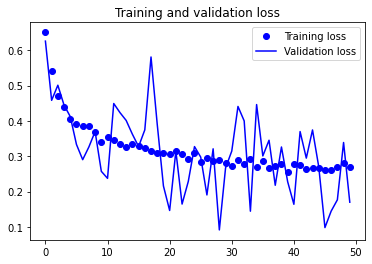

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

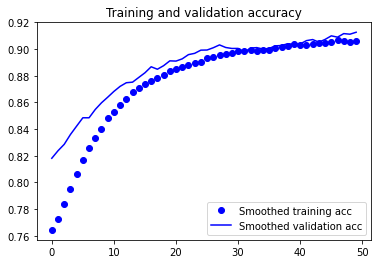

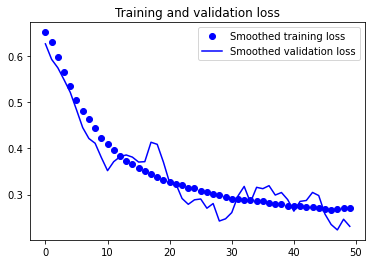

In [21]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.9054999947547913
Wall time: 11.8 s


## Batch_size = 32

In [11]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [16]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 47s 368ms/step - loss: 0.7747 - acc: 0.7207 - val_loss: 0.6096 - val_acc: 0.7856
Epoch 2/50
128/128 [==============================] - 43s 337ms/step - loss: 0.6441 - acc: 0.7637 - val_loss: 0.3799 - val_acc: 0.8231
Epoch 3/50
128/128 [==============================] - 41s 316ms/step - loss: 0.5621 - acc: 0.7925 - val_loss: 0.5037 - val_acc: 0.8225
Epoch 4/50
128/128 [==============================] - 38s 299ms/step - loss: 0.4838 - acc: 0.8232 - val_loss: 0.4170 - val_acc: 0.8537
Epoch 5/50
128/128 [==============================] - 39s 301ms/step - loss: 0.4761 - acc: 0.8276 - val_loss: 0.3527 - val_acc: 0.8481
Epoch 6/50
128/128 [==============================] - 39s 303ms/step - loss: 0.4435 - acc: 0.8411 - val_loss: 0.3734 - val_acc: 0.8381
Epoch 7/50
128/128 [==============================] - 41s 318ms/step - loss: 0.4052 - acc: 0.8545 - val_loss: 0.2093 - val_acc: 0.8800
Epoch 8/50
128/128 [==============================] - 4

In [17]:
model.save('VGG16_batch32.h5')

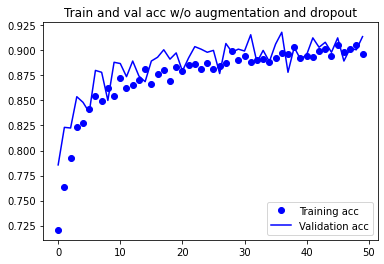

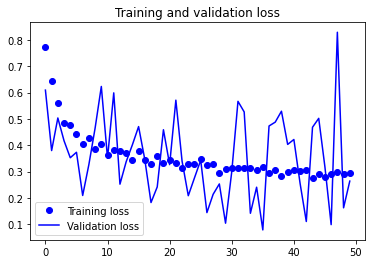

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

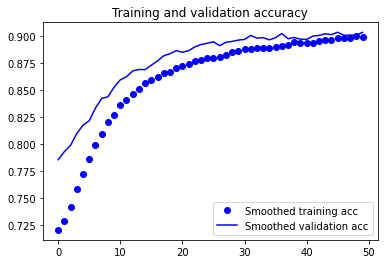

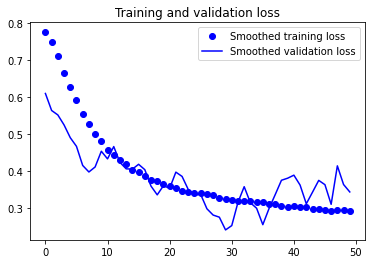

In [19]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.8964999914169312
Wall time: 14.2 s
